In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table

from pymc import Model, Normal, Gamma
from scipy.stats import poisson
from sklearn.linear_model import LinearRegression
import arviz as az
import pymc as pm
from scipy.stats import probplot
import statsmodels.api as sm
df = Table.read('https://www.astro.keele.ac.uk/jkt/debcat/debs.dat', format='ascii').to_pandas()

#filter out erroneous values
df = df[df['logL1'] > -3]


In [3]:
#Fetching the data + errors 
logT1 = np.array(df["logT1"])
logT1e = np.array(df["logT1e"])
logL1 = np.array(df["logL1"])
logL1e = np.array(df["logL1e"])
logR1 = np.array(df["logR1"])
logR1e = np.array(df["logR1e"])

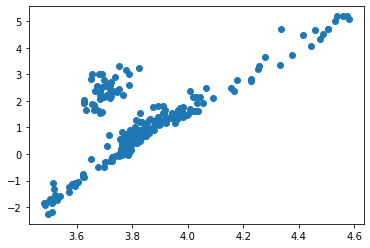

In [5]:
plt.scatter(logT1, logL1)


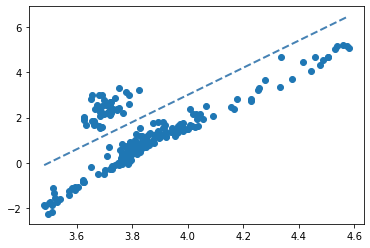

In [36]:
x = np.arange(3.5, 4.6, 0.01)
y = 6*x - 21
plt.scatter(logT1, logL1)
#plt.plot(x, y, color='steelblue', linestyle='--', linewidth=2)
plt.plot(logT1, 6*logT1 -21, color='steelblue', linestyle='--', linewidth=2)

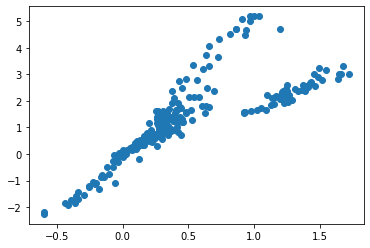

In [8]:
plt.scatter(logR1, logL1)

### Radius and Temperature models with uncertainties 

One that includes errors in both x and y. 

Model: refer to LinearRegressionME.pdf 

Section: Bayesian linear regression with measurement error

We want to model the absolute magnitude MV as a linear function of the two predictors, LogP=Xstar$_1$. Our statistical model can be written as:

$$Ystar_i \sim N(Y_i,a^{-1})$$ 
$$Y_i\sim N (X_i\beta, \tau^{-1})$$
$$Xstar_i \sim N(X_i, b^{-1})$$
$$X_i\sim N(0, c^{-1}),\ iid$$
$$\beta\sim N_2(0, d^{-1}I_2)$$
$$\tau\sim Gamma(e, f)$$

In [10]:

x1 = logT1
x2 = logR1
y = logL1

ye = logL1e ** (-2)
x1e = logT1e ** (-2)
x2e = logR1e ** (-2)
y_obs = y
x1_obs = x1
x2_obs = x2
c = d = 1e-3
e = f = 0.5

In [16]:
# one that does not include errors
basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    tau = Gamma('tau', alpha=e, beta=f)
    X1 = Normal("X1", mu=0, tau=tau, shape=logT1.shape[0])
    X2 = Normal("X2", mu=0, tau=tau, shape=logT1.shape[0])

    beta = Normal('beta', mu=0, tau=d, shape=3)
    Y = Normal("Y", mu=beta[0] + beta[1]*X1 + beta[2]*X2, tau=tau)
    # Likelihood (sampling distribution) of observations
    Y_star = Normal('Y_star', mu=Y, tau=ye, observed=y_obs)
    X1_star = Normal('X1_star', mu=X1, tau=x1e, observed=x1_obs)
    X2_star = Normal('X2_star', mu=X2, tau=x2e, observed=x2_obs)

In [17]:
from pymc import find_MAP
import pprint
pp = pprint.PrettyPrinter(indent=4)
map_estimate = find_MAP(model = basic_model)
pp.pprint(map_estimate)


{   'X1': array([3.48290793, 3.49592198, 3.5099812 , 3.51487628, 3.48557925,
       3.5128931 , 3.52798122, 3.49966625, 3.50379088, 3.53863002,
       3.51799381, 3.57197386, 3.52187663, 3.59290775, 3.57189208,
       3.6049739 , 3.58190772, 3.59284919, 3.62792192, 3.62368601,
       3.79598112, 3.62292012, 3.69880299, 3.78393925, 3.78996268,
       3.62269754, 3.78495138, 3.77189181, 3.79298116, 3.78693929,
       3.67685019, 3.78893937, 3.72585622, 3.77999383, 3.77499386,
       3.74890753, 3.72797396, 3.70187667, 3.75995143, 3.72078894,
       3.76393942, 3.68597391, 3.73995147, 3.75095263, 3.62666723,
       3.69693955, 3.75394996, 3.77696174, 3.64989183, 3.78699386,
       3.75990772, 3.7629215 , 3.77193934, 3.77097386, 3.626659  ,
       3.77296271, 3.76398763, 3.77493912, 3.62484934, 3.76696273,
       3.77298116, 3.7819812 , 3.77096258, 3.78796276, 3.77790764,
       3.77096278, 3.7749812 , 3.63180571, 3.80099386, 3.78098118,
       3.80398759, 3.78296273, 3.77798122, 3.792903

In [20]:
RANDOM_SEED = 5731
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")

with basic_model:
    start = find_MAP() 
    #step = pm.Metropolis()
    # draw 1000 posterior samples
    trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000) # step=step

Running on PyMC v4.3.0


/var/folders/vs/7tzk_bdj4kn_8520tqfg1c6m0000gn/T/ipykernel_16969/634972940.py:12: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, X1, X2, beta, Y]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 134 seconds.


In [21]:
trace.posterior.dims

Frozen({'chain': 4, 'draw': 10000, 'X1_dim_0': 262, 'X2_dim_0': 262, 'beta_dim_0': 3, 'Y_dim_0': 262})

In [22]:
posterior = trace.posterior
posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 10000, X1_dim_0: 262, X2_dim_0: 262,
                 beta_dim_0: 3, Y_dim_0: 262)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * X1_dim_0    (X1_dim_0) int64 0 1 2 3 4 5 6 7 ... 255 256 257 258 259 260 261
  * X2_dim_0    (X2_dim_0) int64 0 1 2 3 4 5 6 7 ... 255 256 257 258 259 260 261
  * beta_dim_0  (beta_dim_0) int64 0 1 2
  * Y_dim_0     (Y_dim_0) int64 0 1 2 3 4 5 6 7 ... 255 256 257 258 259 260 261
Data variables:
    X1          (chain, draw, X1_dim_0) float64 3.488 3.504 3.51 ... 4.562 4.627
    X2          (chain, draw, X2_dim_0) float64 -0.3563 -0.6006 ... 1.001 0.9142
    beta        (chain, draw, beta_dim_0) float64 -9.569 2.556 ... 2.766 2.366
    Y           (chain, draw, Y_dim_0) float64 -1.857 -2.239 ... 5.168 5.071
    tau         (chain, draw) float64 0.1884 0.1937 0.2058 ... 0.1923 0.1967
Attributes:
    created_at:                 2022-11-19T17:31:01.421782
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              134.27827906608582
    tuning_steps:               1000

array([[<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>]], dtype=object)

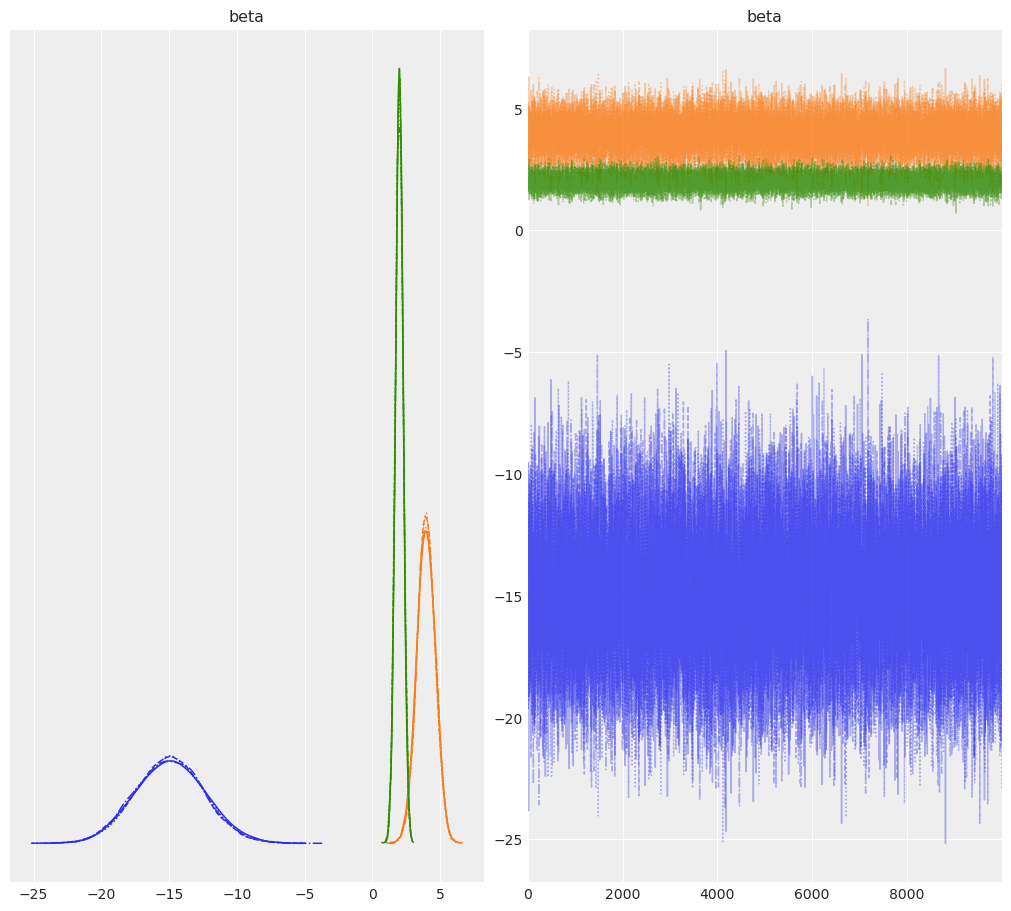

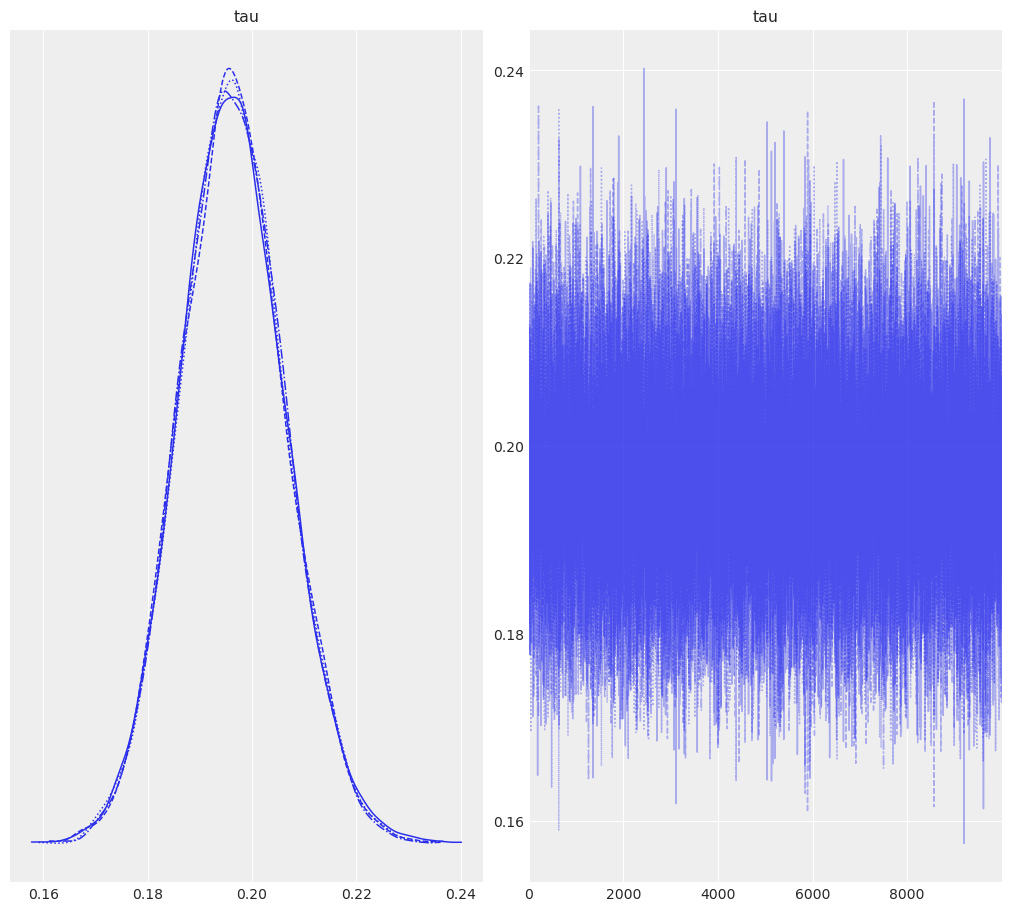

In [23]:
az.plot_trace(trace.posterior["beta"],figsize=(10, 9))
az.plot_trace(trace.posterior["tau"],figsize=(10, 9))

In [24]:
az.summary(trace.posterior[["beta","tau"]], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-14.940,2.559,-19.908,-9.927,0.017,0.012,21853.0,26591.0,1.0
beta[1],3.973,0.670,2.671,5.290,0.005,0.003,21672.0,26084.0,1.0
beta[2],2.001,0.286,1.440,2.565,0.001,0.001,56031.0,30714.0,1.0
tau,0.196,0.010,0.177,0.217,0.000,0.000,58231.0,30628.0,1.0


array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>,
       <AxesSubplot:title={'center':'beta\n2'}>,
       <AxesSubplot:title={'center':'tau'}>], dtype=object)

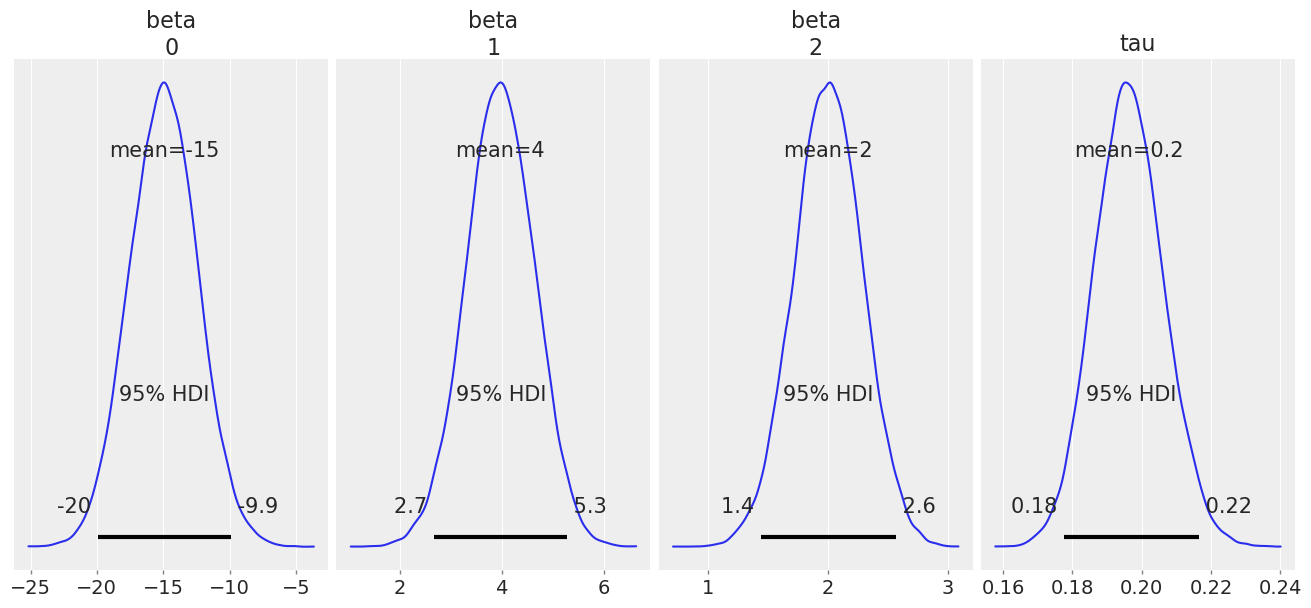

In [25]:
az.plot_posterior(trace.posterior[["beta","tau"]],figsize=(13, 6), hdi_prob=0.95)

In [26]:
print(az.ess(trace,var_names=['beta']))

<xarray.Dataset>
Dimensions:     (beta_dim_0: 3)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1 2
Data variables:
    beta        (beta_dim_0) float64 2.185e+04 2.167e+04 5.603e+04


array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>,
       <AxesSubplot:title={'center':'beta\n2'}>], dtype=object)

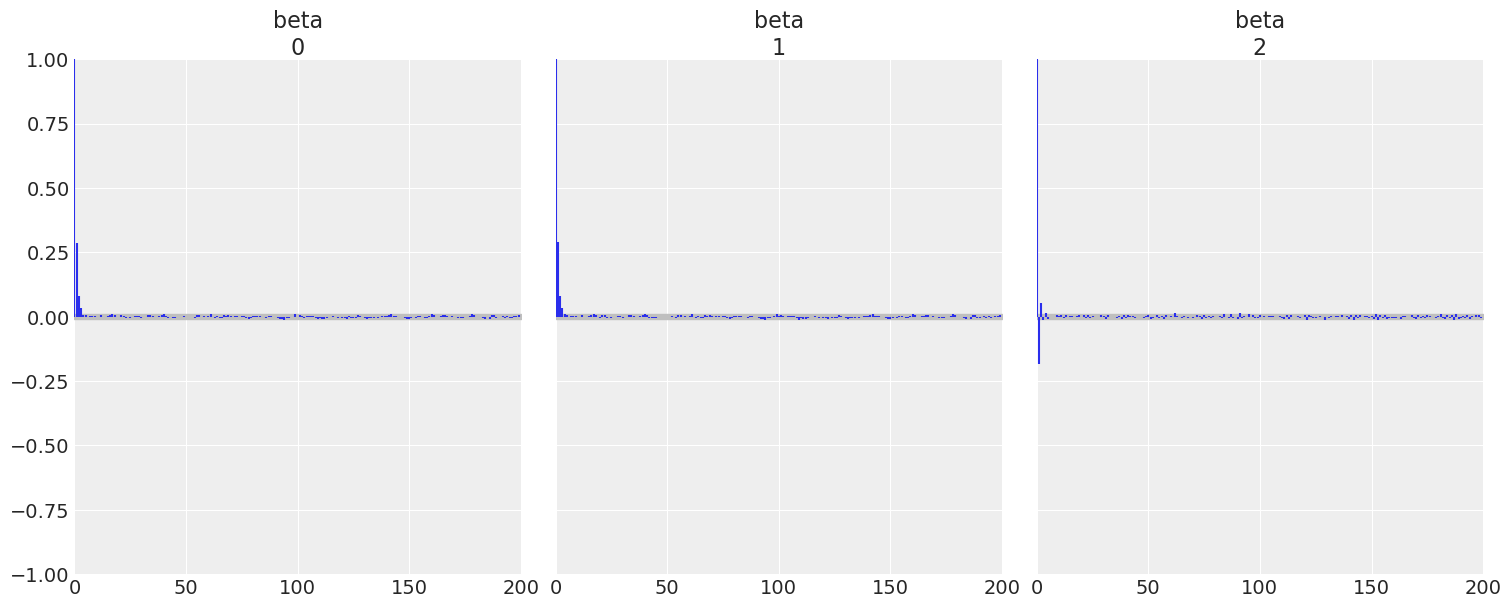

In [27]:
az.plot_autocorr(trace, var_names=['beta'], filter_vars="like",  max_lag=200,combined=True,figsize=(15, 6))

In [28]:
with basic_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

trace.posterior_predictive

Sampling: [X1_star, X2_star, Y_star]


<xarray.Dataset>
Dimensions:        (chain: 4, draw: 10000, Y_star_dim_2: 262,
                    X1_star_dim_2: 262, X2_star_dim_2: 262)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * Y_star_dim_2   (Y_star_dim_2) int64 0 1 2 3 4 5 ... 256 257 258 259 260 261
  * X1_star_dim_2  (X1_star_dim_2) int64 0 1 2 3 4 5 ... 256 257 258 259 260 261
  * X2_star_dim_2  (X2_star_dim_2) int64 0 1 2 3 4 5 ... 256 257 258 259 260 261
Data variables:
    Y_star         (chain, draw, Y_star_dim_2) float64 -1.776 -2.215 ... 5.125
    X1_star        (chain, draw, X1_star_dim_2) float64 3.472 3.517 ... 4.666
    X2_star        (chain, draw, X2_star_dim_2) float64 -0.3591 ... 0.9104
Attributes:
    created_at:                 2022-11-19T17:36:41.464725
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  4.3.0

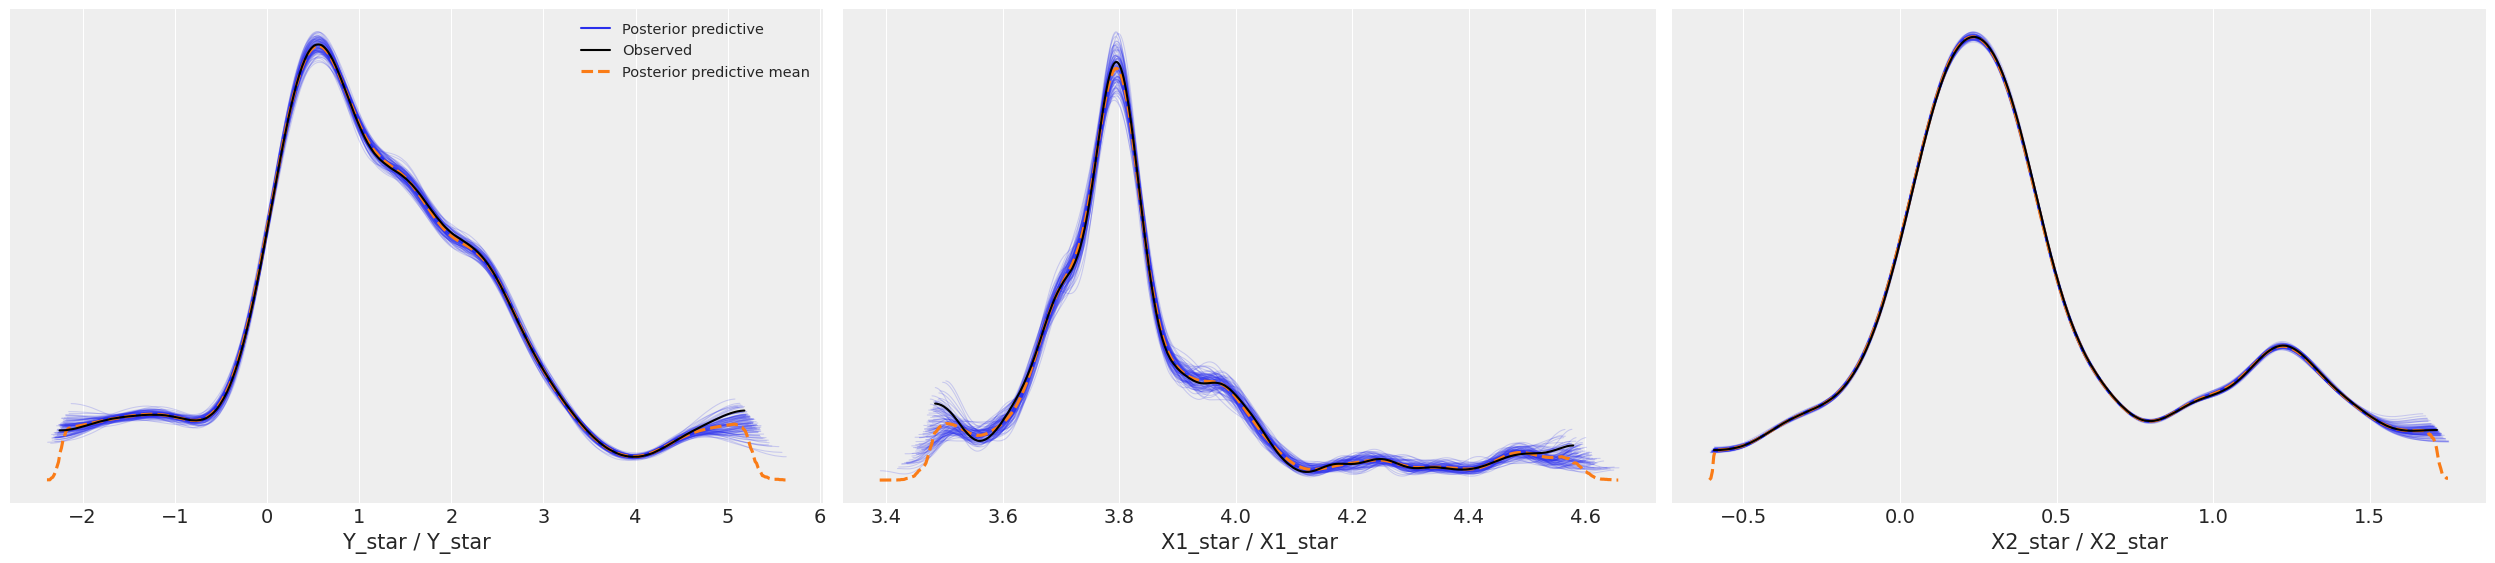

In [29]:
az.plot_ppc(trace, num_pp_samples=100);

In [35]:
import corner


/Users/kietpham/opt/anaconda3/lib/python3.9/site-packages/corner/core.py:103: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(


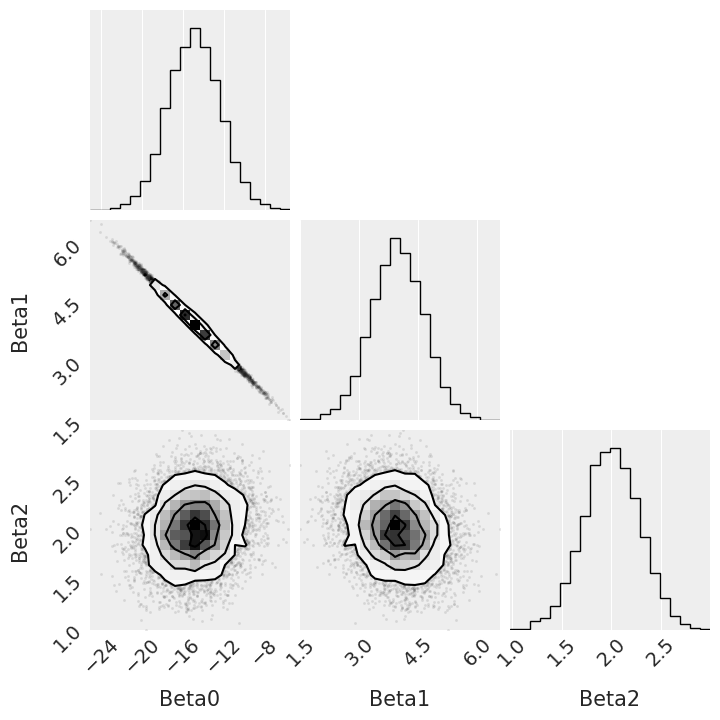

In [38]:
beta0 = trace.posterior["beta"][1,:,0]
beta1 = trace.posterior["beta"][1,:,1]
beta2 = trace.posterior["beta"][1,:,2]

tau = trace.posterior["tau"][1,:] 
samples = np.vstack([beta0, beta1,beta2])
figure = corner.corner(samples.T, labels = ['Beta0','Beta1', 'Beta2'])
#axes = np.array(figure.axes).reshape((ndim, ndim))